# Análisis de preguntas similares

## 1. Importación de librerías

In [1]:
# Generales
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Sklearn
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer  # Stopwords
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import resample

# Tensorflow y Keras
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, Embedding, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, losses
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 2. Carga del csv y configuración de parámetros principales

In [2]:
# Parámetros configurables
N = 20000  # Número de palabras del diccionario
T = 50    # Longitud prefijada de la reseña
D = 100
EPOCHS = 10
NEURONAS = 64

# Usamos la lista de stopwords de sklearn
stop_words = list(ENGLISH_STOP_WORDS)

datos = pd.read_csv("/kaggle/input/preguntas/preguntas.csv")

In [3]:
datos.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
datos['question1'].apply(len).mean()

59.494476666666664

In [5]:
datos.drop(["id", "qid1", "qid2"], axis=1, inplace=True)

In [6]:
datos.head()

,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [9]:
# Unimos las preguntas
datos["preguntas"] = datos["question1"] + " " + datos["question2"]

# Textos de entrada
textos = datos["preguntas"].astype(str).tolist()  # Aseguramos que todo es string

# Parámetros
max_tokens = N        # Número máximo de palabras en el vocabulario
output_sequence_length = T  # Longitud fija de la secuencia
stop_words = set(stop_words)  # Asegúrate que sea un set para que puedas usarlo luego si lo necesitas

# Capa TextVectorization
vectorize_layer = TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=output_sequence_length,
    standardize='lower_and_strip_punctuation',
)

# Adaptamos al texto
vectorize_layer.adapt(textos)

# Aplicamos la vectorización
X = vectorize_layer(tf.constant(textos))

# Si necesitas como NumPy array
X = X.numpy()

In [10]:
datos.head()

,question1,question2,is_duplicate,preguntas
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,What is the step by step guide to invest in sh...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,What is the story of Kohinoor (Koh-i-Noor) Dia...
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,How can I increase the speed of my internet co...
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,Why am I mentally very lonely? How can I solve...
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"Which one dissolve in water quikly sugar, salt..."


In [11]:
y = datos['is_duplicate'].values

In [12]:
y

array([0, 0, 0, ..., 1, 0, 0])

In [13]:
datos.head()

,question1,question2,is_duplicate,preguntas
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,What is the step by step guide to invest in sh...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,What is the story of Kohinoor (Koh-i-Noor) Dia...
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,How can I increase the speed of my internet co...
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,Why am I mentally very lonely? How can I solve...
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"Which one dissolve in water quikly sugar, salt..."


In [14]:
print("X", X.shape)
print("y", y.shape)

X (300000, 50)
y (300000,)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [16]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (240000, 50)
y_train (240000,)
X_test (60000, 50)
y_test (60000,)


In [17]:
model = Sequential([
    Input(shape=(T,)),  # Solo longitud de secuencia (100)
    Embedding(input_dim=N+2, output_dim=D),
    Bidirectional(LSTM(units=NEURONAS)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 50, 100)             │       2,000,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,109,513 (8.05 MB)

 Trainable params: 2,109,513 (8.05 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=EPOCHS, batch_size=128, verbose=1)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.7243 - loss: 0.5395 - val_accuracy: 0.7613 - val_loss: 0.4866
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.7867 - loss: 0.4451 - val_accuracy: 0.7668 - val_loss: 0.4810
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.8250 - loss: 0.3779 - val_accuracy: 0.7782 - val_loss: 0.4760
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.8606 - loss: 0.3118 - val_accuracy: 0.7782 - val_loss: 0.5188
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.8911 - loss: 0.2504 - val_accuracy: 0.7706 - val_loss: 0.5630
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.9124 - loss: 0.2033 - val_accuracy: 0.7701 - val_loss: 0.6301
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.9278 - loss: 0.1707 - val_accuracy: 0.7676 - val_loss: 0.7964
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.9400 -

In [19]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

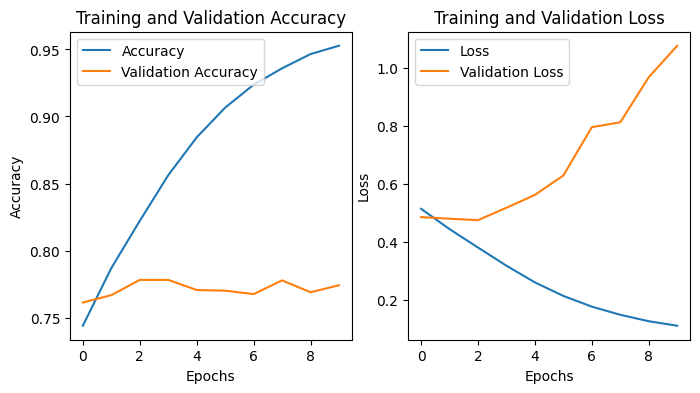

In [20]:
# Plotting the accuracy and loss over time

# Training history
history_dict = history.history

# Seperating validation and training accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Seperating validation and training loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Plotting
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss', 'Validation Loss'])

plt.show()

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step

Reporte de Clasificación:
              precision    recall  f1-score   support

No Duplicado       0.82      0.81      0.82     37756
   Duplicado       0.69      0.70      0.69     22244

    accuracy                           0.77     60000
   macro avg       0.75      0.76      0.75     60000
weighted avg       0.77      0.77      0.77     60000



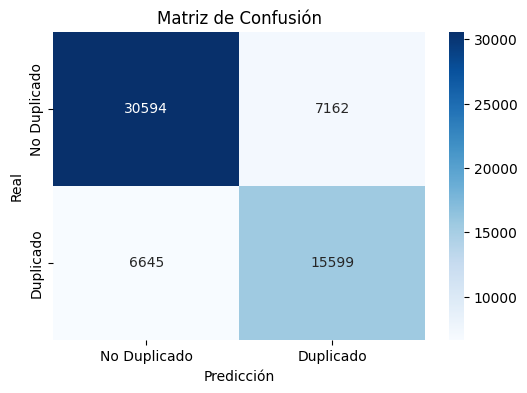

In [21]:
def train_validation(model, X_test, y_test):
   
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Convertir probabilidades en etiquetas binarias

    # Matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Reporte de clasificación
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred, target_names=["No Duplicado", "Duplicado"]))

    # Mostrar matriz de confusión con heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=["No Duplicado", "Duplicado"],
                yticklabels=["No Duplicado", "Duplicado"])
    plt.title("Matriz de Confusión")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

# Llama a la función con el modelo ya entrenado
train_validation(model, X_test, y_test)

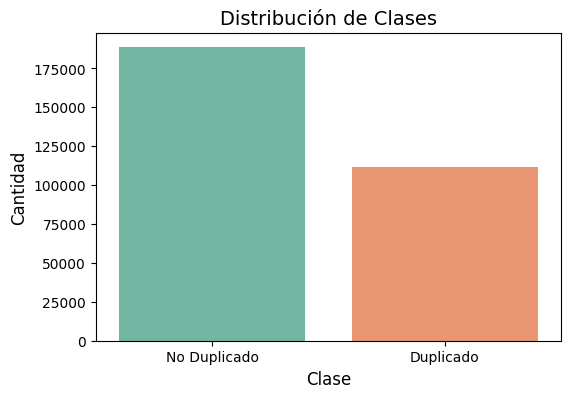

In [22]:
# Supongamos que la columna de clases es 'is_duplicate'
plt.figure(figsize=(6,4))
sns.countplot(data=datos, x='is_duplicate', palette='Set2')

# Etiquetas y título
plt.title("Distribución de Clases", fontsize=14)
plt.xlabel("Clase", fontsize=12)
plt.ylabel("Cantidad", fontsize=12)
plt.xticks([0, 1], ["No Duplicado", "Duplicado"])
plt.show()

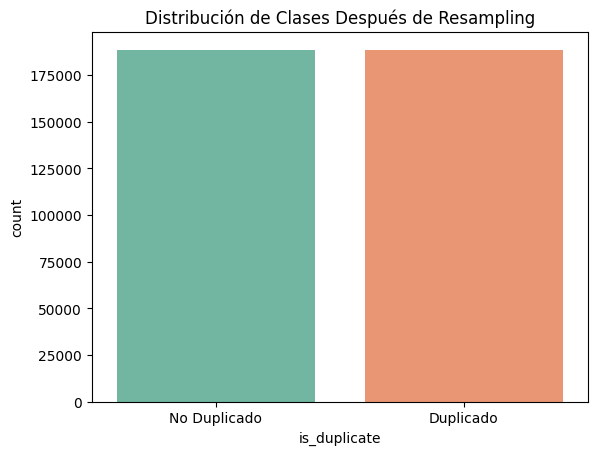

In [23]:
# Separar las clases
clase_mayoritaria = datos[datos['is_duplicate'] == 0]
clase_minoritaria = datos[datos['is_duplicate'] == 1]

# Hacer oversampling de la clase minoritaria
clase_minoritaria_aumentada = resample(
    clase_minoritaria,
    replace=True,                      # muestreo con reemplazo
    n_samples=len(clase_mayoritaria), # igualar al número de la clase mayoritaria
    random_state=42
)

# Combinar para tener un dataset balanceado
datos_balanceado = pd.concat([clase_mayoritaria, clase_minoritaria_aumentada])

# Barajar las filas
datos_balanceado = datos_balanceado.sample(frac=1, random_state=42).reset_index(drop=True)

# Verificar nuevo balance
sns.countplot(data=datos_balanceado, x='is_duplicate', palette='Set2')
plt.title("Distribución de Clases Después de Resampling")
plt.xticks([0, 1], ["No Duplicado", "Duplicado"])
plt.show()


In [24]:
datos_balanceado.head()

,question1,question2,is_duplicate,preguntas
0,What is Netflix? How does it work? How much do...,Is Netflix worth the cost?,0,What is Netflix? How does it work? How much do...
1,What is the future of internet piracy?,What is the most likely future of internet pir...,1,What is the future of internet piracy? What is...
2,What's the most embarrassing moment of your life?,What is your most embarrassing moment ever?,1,What's the most embarrassing moment of your li...
3,Can we donate blood after getting a tattoo?,Can we donate blood after tattoo?,1,Can we donate blood after getting a tattoo? Ca...
4,"I'm planning on exercising quite a lot, as wel...",I'm going to stop eating and drinking anything...,1,"I'm planning on exercising quite a lot, as wel..."


In [29]:
# Unimos las preguntas
datos_balanceado["preguntas"] = datos_balanceado["question1"] + " " + datos_balanceado["question2"]

# Textos de entrada
textos = datos_balanceado["preguntas"].astype(str).tolist()  # Aseguramos que todo es string

# Parámetros
max_tokens = N        # Número máximo de palabras en el vocabulario
output_sequence_length = T  # Longitud fija de la secuencia
stop_words = set(stop_words)  # Asegúrate que sea un set para que puedas usarlo luego si lo necesitas

# Capa TextVectorization
vectorize_layer = TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=output_sequence_length,
    standardize='lower_and_strip_punctuation',
)

# Adaptamos al texto
vectorize_layer.adapt(textos)

# Aplicamos la vectorización
X = vectorize_layer(tf.constant(textos))

# Si necesitas como NumPy array
X = X.numpy()

# La variable objetivo
y = datos_balanceado["is_duplicate"].values  # O la columna que estés usando como etiqueta

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [31]:
model = Sequential([
    Input(shape=(T,)),  # Solo longitud de secuencia (100)
    Embedding(input_dim=N+2, output_dim=D),
    Bidirectional(LSTM(units=NEURONAS, return_sequences=True)),
    Bidirectional(LSTM(units=NEURONAS)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 50, 100)             │       2,000,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 50, 128)             │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,208,329 (8.42 MB)

 Trainable params: 2,208,329 (8.42 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=EPOCHS, batch_size=128, verbose=1)

Epoch 1/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.7202 - loss: 0.5427 - val_accuracy: 0.7789 - val_loss: 0.4710
Epoch 2/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - accuracy: 0.8142 - loss: 0.4129 - val_accuracy: 0.8028 - val_loss: 0.4367
Epoch 3/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - accuracy: 0.8636 - loss: 0.3223 - val_accuracy: 0.8235 - val_loss: 0.4213
Epoch 4/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - accuracy: 0.8989 - loss: 0.2492 - val_accuracy: 0.8322 - val_loss: 0.4301
Epoch 5/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - accuracy: 0.9224 - loss: 0.1979 - val_accuracy: 0.8387 - val_loss: 0.4403
Epoch 6/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - accuracy: 0.9394 - loss: 0.1594 - val_accuracy: 0.8445 - val_loss: 0.4631
Epoch 7/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - accuracy: 0.9503 - loss: 0.1307 - val_accuracy: 0.8434 - val_loss: 0.5000
Epoch 8/10
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - accuracy: 0.9581 -

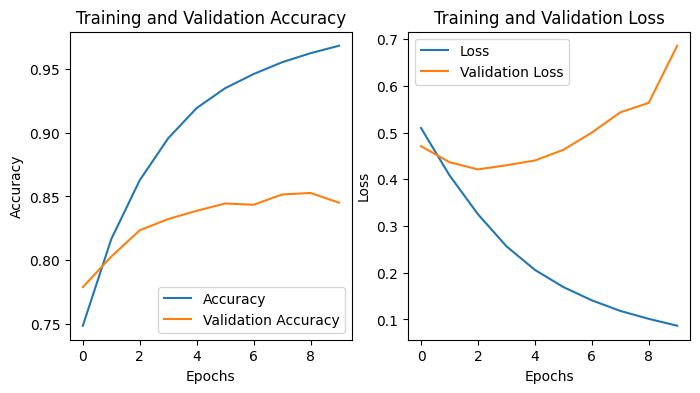

In [33]:
# Training history
history_dict = history.history

# Seperating validation and training accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Seperating validation and training loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Plotting
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss', 'Validation Loss'])

plt.show()

2357/2357 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step

Reporte de Clasificación:
              precision    recall  f1-score   support

No Duplicado       0.88      0.81      0.84     37701
   Duplicado       0.82      0.89      0.85     37710

    accuracy                           0.85     75411
   macro avg       0.85      0.85      0.85     75411
weighted avg       0.85      0.85      0.85     75411



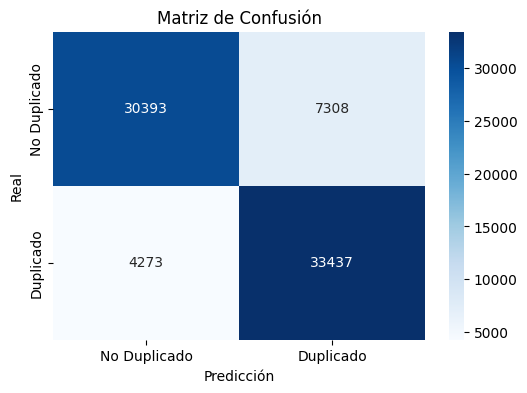

In [34]:
# Llama a la función con el modelo ya entrenado
train_validation(model, X_test, y_test)

### Under sampling

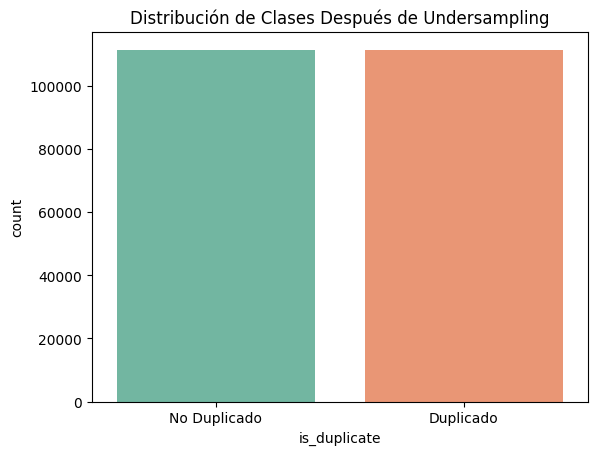

In [35]:
# Separar las clases
clase_mayoritaria = datos[datos['is_duplicate'] == 0]
clase_minoritaria = datos[datos['is_duplicate'] == 1]

# Hacer undersampling de la clase mayoritaria
clase_mayoritaria_reducida = resample(
    clase_mayoritaria,
    replace=False,                         # sin reemplazo
    n_samples=len(clase_minoritaria),      # igualar al número de la clase minoritaria
    random_state=42
)

# Combinar para tener un dataset balanceado
datos_balanceado = pd.concat([clase_mayoritaria_reducida, clase_minoritaria])

# Barajar las filas
datos_balanceado = datos_balanceado.sample(frac=1, random_state=42).reset_index(drop=True)

# Verificar nuevo balance
sns.countplot(data=datos_balanceado, x='is_duplicate', palette='Set2')
plt.title("Distribución de Clases Después de Undersampling")
plt.xticks([0, 1], ["No Duplicado", "Duplicado"])
plt.show()


In [36]:
# Unimos las preguntas
datos_balanceado["preguntas"] = datos_balanceado["question1"] + " " + datos_balanceado["question2"]

# Textos de entrada
textos = datos_balanceado["preguntas"].astype(str).tolist()  # Aseguramos que todo es string

# Parámetros
max_tokens = N        # Número máximo de palabras en el vocabulario
output_sequence_length = T  # Longitud fija de la secuencia
stop_words = set(stop_words)  # Asegúrate que sea un set para que puedas usarlo luego si lo necesitas

# Capa TextVectorization
vectorize_layer = TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=output_sequence_length,
    standardize='lower_and_strip_punctuation',
)

# Adaptamos al texto
vectorize_layer.adapt(textos)

# Aplicamos la vectorización
X = vectorize_layer(tf.constant(textos))

# Si necesitas como NumPy array
X = X.numpy()

# La variable objetivo
y = datos_balanceado["is_duplicate"].values  # O la columna que estés usando como etiqueta

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [46]:
model = Sequential([
    Input(shape=(T,)),  # Solo longitud de secuencia (100)
    Embedding(input_dim=N+2, output_dim=D),
    Bidirectional(LSTM(units=NEURONAS)),
    #Bidirectional(LSTM(units=NEURONAS)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 50, 100)             │       2,000,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 128)                 │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,093,001 (7.98 MB)

 Trainable params: 2,093,001 (7.98 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=EPOCHS, batch_size=128, verbose=1)

Epoch 1/10
1115/1115 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.6967 - loss: 0.5694 - val_accuracy: 0.7324 - val_loss: 0.5411
Epoch 2/10
1115/1115 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.7693 - loss: 0.4792 - val_accuracy: 0.7453 - val_loss: 0.5137
Epoch 3/10
1115/1115 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.8063 - loss: 0.4138 - val_accuracy: 0.7512 - val_loss: 0.5286
Epoch 4/10
1115/1115 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.8466 - loss: 0.3434 - val_accuracy: 0.7496 - val_loss: 0.5725
Epoch 5/10
1115/1115 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.8798 - loss: 0.2772 - val_accuracy: 0.7510 - val_loss: 0.6021
Epoch 6/10
1115/1115 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.9074 - loss: 0.2204 - val_accuracy: 0.7494 - val_loss: 0.7094
Epoch 7/10
1115/1115 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.9247 - loss: 0.1813 - val_accuracy: 0.7489 - val_loss: 0.8868
Epoch 8/10
1115/1115 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.9395 -

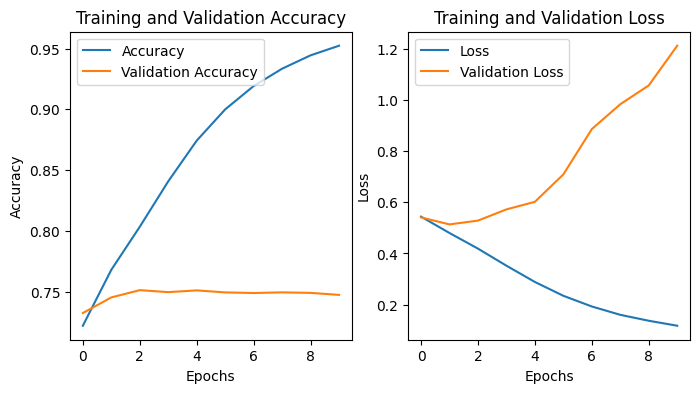

In [48]:
# Training history
history_dict = history.history

# Seperating validation and training accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Seperating validation and training loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Plotting
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss', 'Validation Loss'])

plt.show()

1394/1394 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

Reporte de Clasificación:
              precision    recall  f1-score   support

No Duplicado       0.76      0.72      0.74     22341
   Duplicado       0.74      0.78      0.76     22249

    accuracy                           0.75     44590
   macro avg       0.75      0.75      0.75     44590
weighted avg       0.75      0.75      0.75     44590



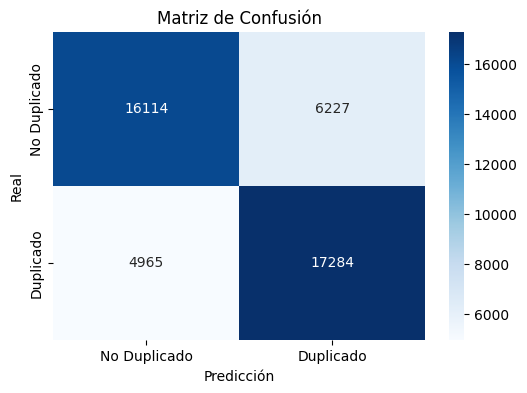

In [49]:
train_validation(model, X_test, y_test)